### Transferring to the newer Pytorch Lightning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, custom_format, currency_format

from IPython.display import clear_output

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
pd.set_option('display.max.columns', 500)

In [2]:
# Read data
data = (pd.read_csv("data_prepped.csv", parse_dates=['date'])
        .assign(year=lambda x: x.date.dt.year))

# Splitting data by time
dt_train = data.query("year <= 2017")
dt_test = data.query("year == 2018")
holdout = data.query("year == 2019")

In [6]:
# Prepare data
X_train = dt_train.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_train = dt_train["mwh"].reset_index(drop=True)

X_test = dt_test.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_test = dt_test["mwh"].reset_index(drop=True)

X_holdout = holdout.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_holdout = holdout["mwh"].reset_index(drop=True)

In [8]:
class CustomDataset(Dataset):
    '''
    Prepare the custom dataset for regression
    '''
    def __init__(self, X, y):
      self.X = torch.from_numpy(np.float32(np.asarray(X)))
      self.y = torch.from_numpy(np.float32(np.asarray(y)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [9]:
train_dataset = CustomDataset(X=X_train, y=y_train)
test_dataset = CustomDataset(X=X_test, y=y_test)
holdout_dataset = CustomDataset(X=X_holdout, y=y_holdout)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=32, shuffle=False)

In [12]:
class ANN(pl.LightningModule):
    '''
    Artificial Neural Network
    '''
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.loss_fn = nn.L1Loss()

    def forward(self, x):
        '''
        Forward pass
        '''
        return self.layers(x)
    
    def predict_step(self, batch, batch_idx):
        x, y_ = batch
        return self(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, on_step=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log('test_loss', loss, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [13]:
model = ANN(input_dim=X_train.shape[1])

# create the trainer
logger = CSVLogger('logs', name='ann', version=0)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=15)

trainer = pl.Trainer(max_epochs=300, logger=logger, enable_progress_bar=True,
                     callbacks=[early_stopping_callback])
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory logs\ann\version_0\checkpoints exists and is not empty.

  | Name    | Type       | Params
---------------------------------------
0 | layers  | Sequential | 72.6 K
1 | loss_fn | L1Loss     | 0     
---------------------------------------
72.6 K    Trainable params
0         Non-trainable params
72.6 K    Total params
0.290     Total estimated model params size (MB)
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\lightning_fabric\loggers\csv_logs.py:183: UserWarning: Experiment logs directory logs\ann\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
metrics = pd.read_csv("logs/ann/version_0/metrics.csv")

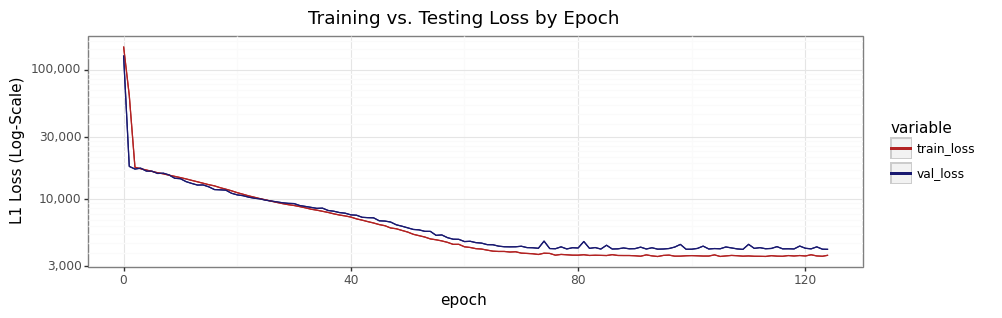

<ggplot: (129528788869)>

In [29]:
train_losses = (metrics
 .dropna(subset=['epoch', 'train_loss'])
 .filter(['epoch', 'train_loss'])
 .reset_index(drop=True)
 )

validation_losses = (metrics
 .dropna(subset=['epoch', 'val_loss'])
 .filter(['epoch', 'val_loss'])
 .reset_index(drop=True)
 )

p = (
    ggplot(data=(train_losses
                 .merge(validation_losses, how='left')
                 .melt(id_vars='epoch')
                 ),
           mapping=aes(x='epoch', y='value', colour='variable')) +
    geom_line() +
    labs(title='Training vs. Testing Loss by Epoch',
         y='L1 Loss (Log-Scale)') +
    geom_line() +
    scale_y_log10(labels=comma_format()) +
    scale_colour_manual(values=['firebrick', 'midnightblue']) +
    theme_bw() +
    theme(figure_size=[10, 3])
)

p

In [30]:
p.save(dpi=350, filename='python4.png')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 10 x 3 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python4.png


In [16]:
trainer.test(dataloaders=holdout_loader)

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs\ann\version_0\checkpoints\epoch=124-step=12875-v2.ckpt
Loaded model weights from checkpoint at logs\ann\version_0\checkpoints\epoch=124-step=12875-v2.ckpt
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             3910.083984375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 3910.083984375}]

In [17]:
holdout_preds = trainer.predict(model=model, dataloaders=holdout_loader)

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Predicting: 103it [00:00, ?it/s]

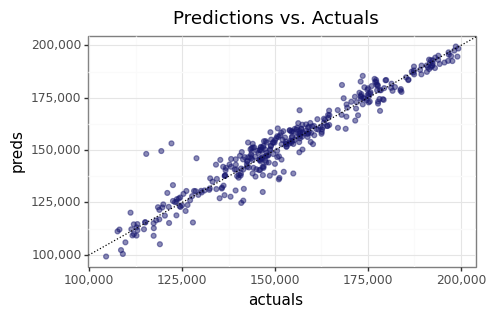

<ggplot: (129528203060)>

In [21]:
(
    ggplot(data=(pd.DataFrame({'preds': torch.cat(holdout_preds).numpy().ravel(),
                               'actuals': holdout.mwh})
                 ),
           mapping=aes(x='actuals', y='preds')) +
    geom_point(alpha=0.5, colour='midnightblue') +
    geom_abline(linetype='dotted') +
    labs(title='Predictions vs. Actuals') +
    scale_y_continuous(labels=comma_format()) +
    scale_x_continuous(labels=comma_format()) +
    theme_bw() +
    theme(figure_size=[5, 3])
)


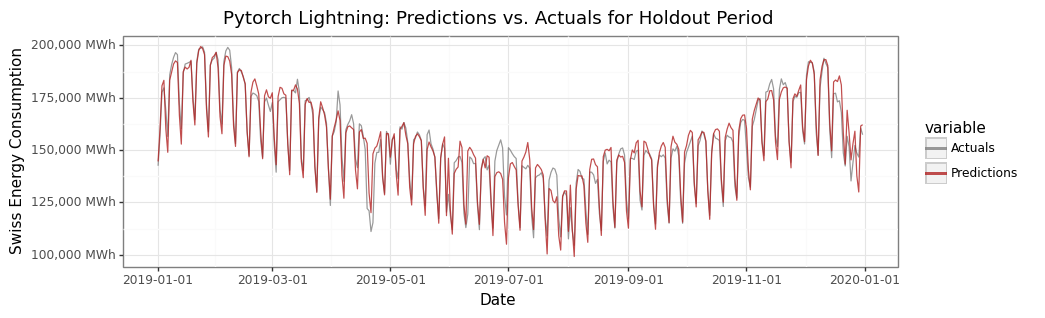

<ggplot: (129528258831)>

In [24]:
p = (
    ggplot(data=(pd.DataFrame({'Predictions': torch.cat(holdout_preds).numpy().ravel(),
                               'Actuals': holdout['mwh'],
                               'Date': holdout['date']})
                 .melt(id_vars='Date')
                 ),
           mapping=aes(x='Date', y='value', colour='variable')) +
    geom_line(alpha=0.8) +
    labs(title='Pytorch Lightning: Predictions vs. Actuals for Holdout Period',
         y='Swiss Energy Consumption') +
    scale_y_continuous(labels=currency_format(prefix='',
                                              suffix=' MWh',
                                              big_mark=',',
                                              digits=0)) +
    scale_colour_manual(values=['grey', 'firebrick']) +
    theme_bw() +
    theme(figure_size=[10, 3])
)

p


In [25]:
p.save(dpi=350, filename='python.png')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 10 x 3 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python.png
